# Aperiodic mode
Compare model error for 'fixed' and 'knee' SpecParam' modes.

## Set-up

### Imports

In [24]:
# standard
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rcParams

from specparam import SpectralModel, SpectralGroupModel


In [25]:
# custom
import sys
sys.path.append(f"../code")
from paths import PROJECT_PATH
from info import FS, PATIENTS
from settings import (BANDS, SPEC_PARAM_SETTINGS, WINDOW, TFR_METHOD, 
    N_TFR_SAMPLES, N_JOBS, FREQ_RANGE, RGB, WIDTH)
from specparam_utils import compute_adj_r2


### Settings

In [26]:
plt.style.use("../mplstyle/default.mplstyle")

In [27]:
# settings
TMIN = -1.5 # epoch start time


### Functions

## Main

### Compare r-squared between aperiodic modes

Mean r-squared values for each model across all conditions:
Knee: 	0.976
Fixed: 	0.960


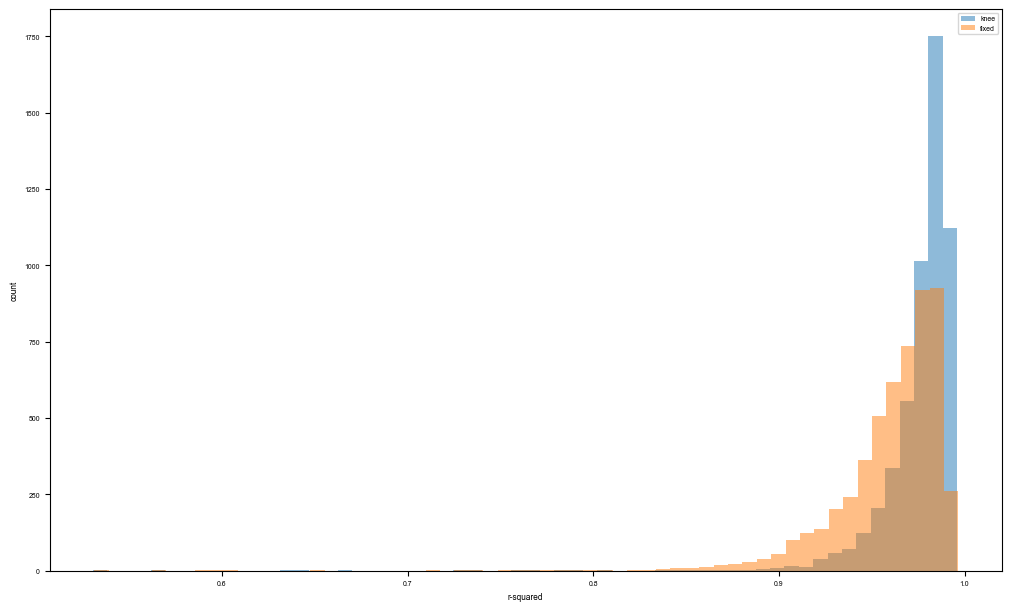

In [28]:
# Import r-squared values for each aperiodic model across all conditions

# init
r2_knee = []
r2_fixed = []

for material in ['words','faces']:
    for memory in ['hit','miss']:
        for window in ['pre', 'post']:
            # load r-squared values for 'knee' model
            fg_k = SpectralGroupModel()
            fg_k.load(f'{PROJECT_PATH}/data/ieeg_psd_param/psd_{material}_{memory}_{window}stim_params_knee')
            # r2_k = fg_k.get_params('r_squared')
            r2_k = compute_adj_r2(fg_k)
            r2_knee.append(r2_k)

            # load r-squared values for 'fixed' model
            fg_f = SpectralGroupModel()
            fg_f.load(f'{PROJECT_PATH}/data/ieeg_psd_param/psd_{material}_{memory}_{window}stim_params_fixed')
            # r2_f = fg_f.get_params('r_squared')
            r2_f = compute_adj_r2(fg_f)
            r2_fixed.append(r2_f)

# concatenate
r2_knee = np.concatenate(r2_knee)
r2_fixed = np.concatenate(r2_fixed)

# print mean
print("Mean r-squared values for each model across all conditions:")
print(f"Knee: \t{np.nanmean(r2_knee):.3f}")
print(f"Fixed: \t{np.nanmean(r2_fixed):.3f}")

# plot histogram of results
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(r2_knee, bins=60, alpha=0.5, label='knee')
ax.hist(r2_fixed, bins=60, alpha=0.5, label='fixed')
ax.set(xlabel="r-squared", ylabel="count")
ax.legend()

plt.show()


In [29]:
# there are a few outliers with poor fits 

# print the min values
print("Min r-squared values:")
print(f"knee: {np.nanmin(r2_knee):.2f}, fixed: {np.nanmin(r2_fixed):.2f}")

# print the number/percentage of fits with r-squred less than 0.9 for each model
print("\nNumber of fits with r-squared less than 0.9:")
print(f"knee: {np.sum(r2_knee < 0.9)}, fixed: {np.sum(r2_fixed < 0.9)}")
print("\nPercentage of fits with r-squared less than 0.9:")
print(f"knee: {np.sum(r2_knee < 0.9)/len(r2_knee)*100:.2f}%, fixed: {np.sum(r2_fixed < 0.9)/len(r2_fixed)*100:.2f}%")

Min r-squared values:
knee: 0.53, fixed: 0.53

Number of fits with r-squared less than 0.9:
knee: 41, fixed: 194

Percentage of fits with r-squared less than 0.9:
knee: 0.74%, fixed: 3.49%


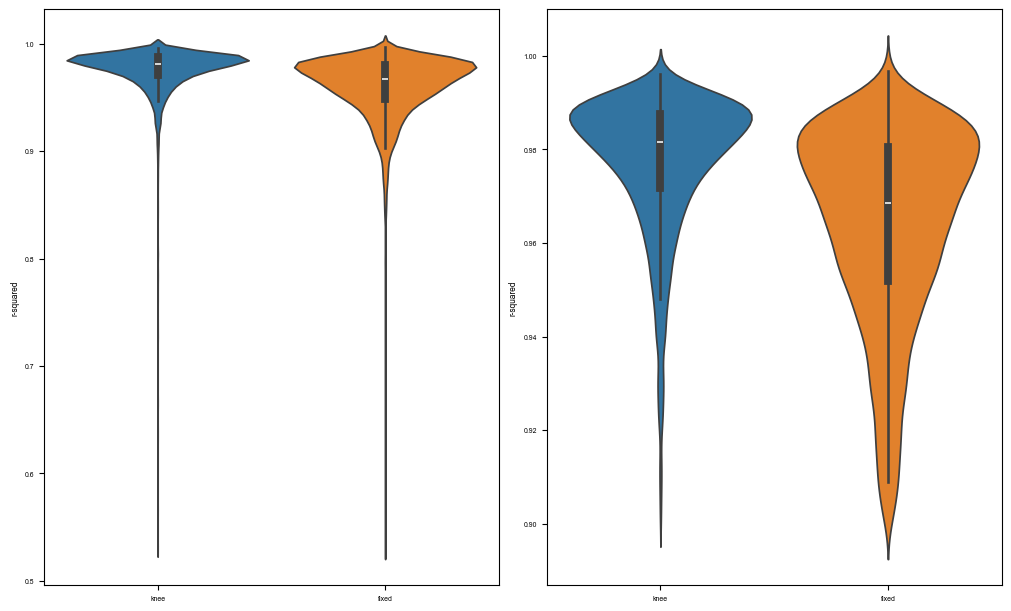

In [30]:
# plot violin plot of r-suared results
import seaborn as sns

# remove nan
r2_knee_ = r2_knee[~np.isnan(r2_knee)]
r2_fixed_ = r2_fixed[~np.isnan(r2_fixed)]

# plot
fig, (ax, ax_zoom) = plt.subplots(1,2, figsize=(10, 6))
# ax.violinplot([r2_knee_, r2_fixed_], showmeans=True, )
sns.violinplot(data=[r2_knee_, r2_fixed_], ax=ax)
ax.set(xticks=[0, 1], xticklabels=['knee', 'fixed'], ylabel="r-squared")

# plot - remove outliers 
sns.violinplot(data=[r2_knee_[r2_knee_>.9], r2_fixed_[r2_fixed_>.9]], ax=ax_zoom)
ax_zoom.set(xticks=[0, 1], xticklabels=['knee', 'fixed'], ylabel="r-squared")

plt.show()

Mean difference: 0.016
Percent with positive difference: 0.799


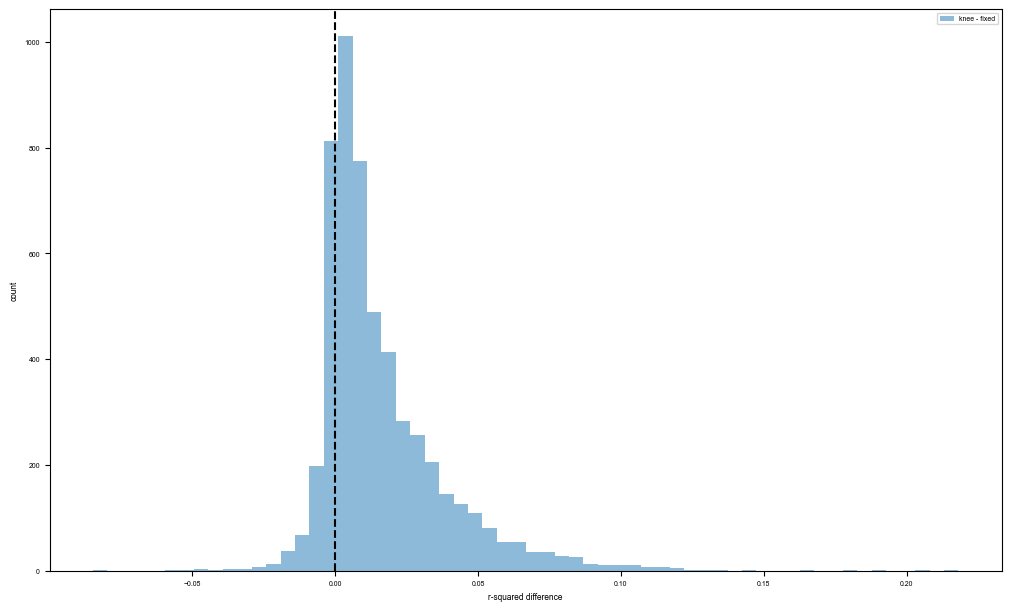

In [31]:
# compute difference in r-squared betwen models
r2_diff = r2_knee - r2_fixed
print(f"Mean difference: {np.nanmean(r2_diff):.3f}")
print(f"Percent with positive difference: {np.sum(r2_diff > 0) / len(r2_diff):.3f}")

# plot histogram of results
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(r2_diff, bins=60, alpha=0.5, label='knee - fixed')
ax.set(xlabel="r-squared difference", ylabel="count")
ax.axvline(0, color='k', linestyle='--')
ax.legend();

Although the difference in r-squared between models is small, when we compared r-squared values on a  channel-by-channel basis, 73% of channels exhibit greater r-squared values when fit with the 'knee' model.

### Fit grand-average PSD with both apeiodic modes

spectra_cond shape: (4, 513)
psd shape: (513,)


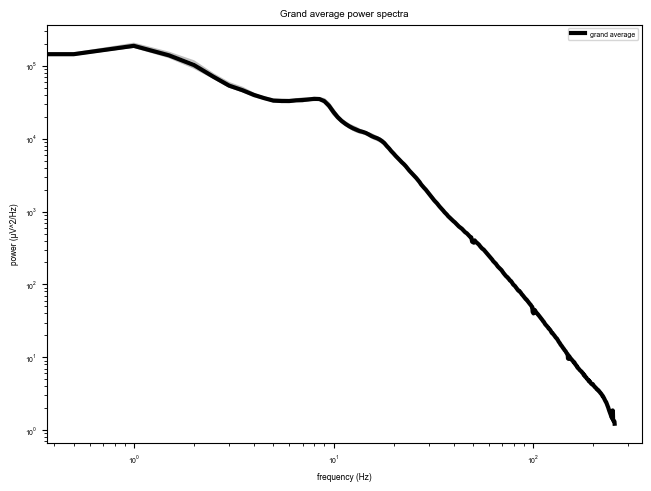

In [32]:
# load all PSDs
dir_input = f'{PROJECT_PATH}/data/ieeg_spectral_results'
files = [f for f in os.listdir(dir_input) if (('psd' in f) and ('epoch' in f))]

# init
temp = np.load(f"{dir_input}/{files[0]}")
spectra = np.zeros([len(files), temp['spectra'].shape[0], temp['spectra'].shape[1]])
freq = temp['freq']
del temp

# load spectra for each condition
for i_file, fname_in in enumerate(files):
    data_in = np.load(f"{dir_input}/{fname_in}")
    spectra[i_file] = data_in['spectra']
    
# average over channels and compute granda verage
spectra_cond = np.nanmean(spectra, axis=1)
psd = np.nanmean(spectra_cond, axis=0)
print(f"spectra_cond shape: {spectra_cond.shape}")
print(f"psd shape: {psd.shape}")

# plot
fig, ax = plt.subplots()
ax.loglog(freq, spectra_cond.T, color='grey', alpha=0.5)
ax.loglog(freq, psd, label='grand average', color='k', linewidth=3)
ax.set(xlabel="frequency (Hz)", ylabel="power (\u03BCV^2/Hz)")
ax.set_title("Grand average power spectra")
ax.legend();


In [33]:
# fit power spectra with both aperiodic modes and compre r-squared

# settings
specparam_settings = SPEC_PARAM_SETTINGS.copy()

# fit 'knee'
fg_k = SpectralModel(aperiodic_mode='knee', **specparam_settings)
fg_k.fit(freq, psd)
# r2_k = fg_k.get_params('r_squared')
r2_k = compute_adj_r2(fg_k)

# fit 'fixed'
fg_f = SpectralModel(aperiodic_mode='fixed', **specparam_settings)
fg_f.fit(freq, psd)
# r2_f = fg_f.get_params('r_squared')
r2_f = compute_adj_r2(fg_f)

# print
print(f"r-squared values for each model:")
print(f"Knee: \t{r2_k:.3f}")
print(f"Fixed: \t{r2_f:.3f}")



FITTING WARNING: Skipping frequency == 0, as this causes a problem with fitting.

FITTING WARNING: Skipping frequency == 0, as this causes a problem with fitting.
r-squared values for each model:
Knee: 	0.996
Fixed: 	0.954


                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                       The model was run on the frequency range 0 - 256 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          7.0381, 2.7429                                          
                                                                                                  
                                       0 peaks were found:                                        
          

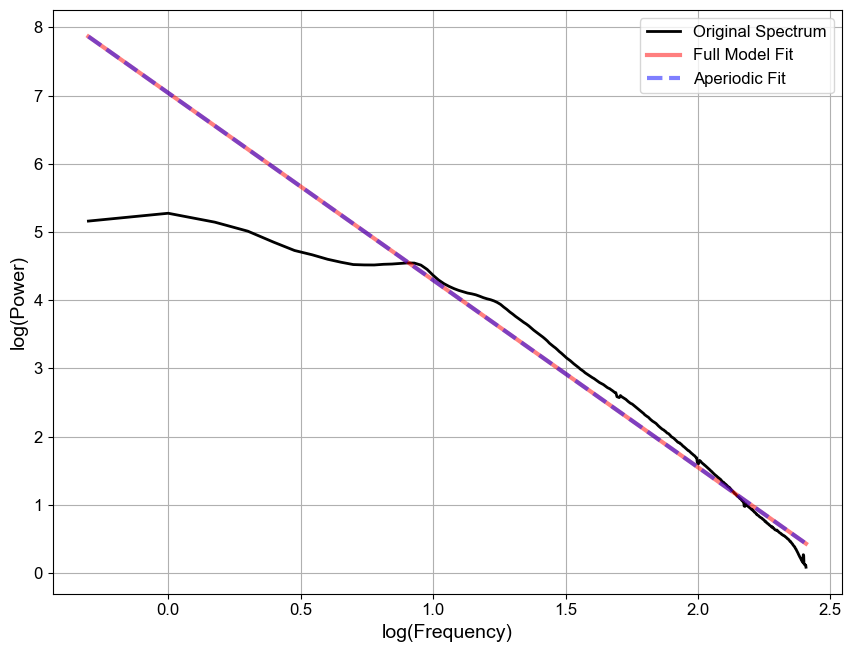

In [34]:
# show report - fixed
fg_f.report(plt_log=True)

                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                       The model was run on the frequency range 0 - 256 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    8.1869, 3048.9263, 3.2897                                     
                                                                                                  
                                       0 peaks were found:                                        
          

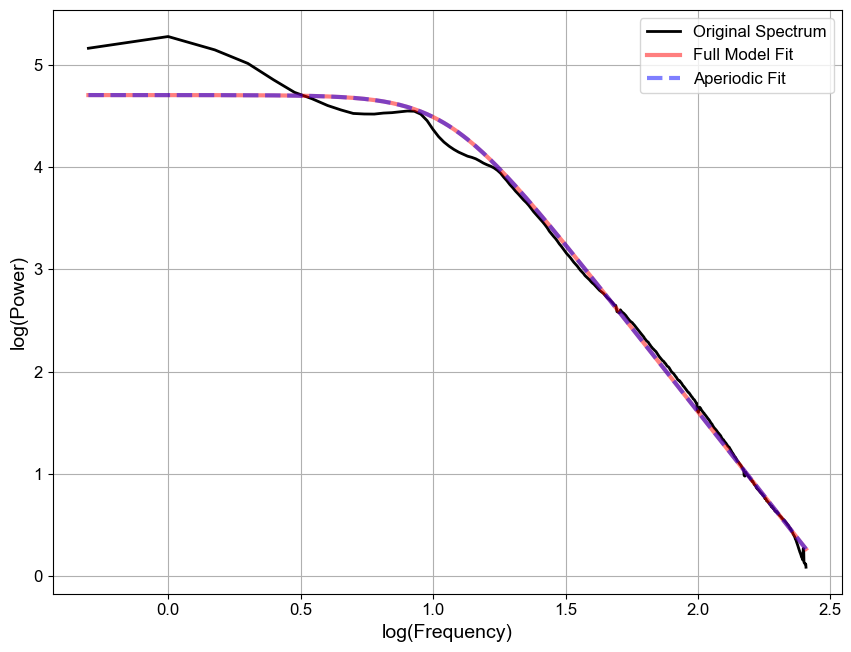

In [35]:
# show report - knee
fg_k.report(plt_log=True)

This analysis demonstrates that a high r-suared value does not necessarilly indicate a 'good' fit. Here we see the 'fixed' model has an r-squared value of 0.98, yet it does not capture the data well (fitting a broad peak to what appears to be a 'knee' component). Note: in general, we do not recommend fitting channel-averaged power spectra

### Summary Figure

In [36]:
# # create figure and gridspec
# fig = plt.figure(figsize=[12,8], constrained_layout=True)
# spec = gridspec.GridSpec(figure=fig, ncols=2, nrows=2, width_ratios=[1,1], height_ratios=[1,1])
# # ax1 = fig.add_subplot(spec[0,0])
# ax2 = fig.add_subplot(spec[1,0])
# ax3 = fig.add_subplot(spec[0,1])
# ax4 = fig.add_subplot(spec[1,1])

# # plot subplot 1 - violin ----------------------------------------------------------------------
# # created nested gridspec
# spec1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=spec[0,0], width_ratios=[1,1])
# ax1a = fig.add_subplot(spec1[0,0])
# ax1b = fig.add_subplot(spec1[0,1])

# # remove outliers
# outlier_thresh_knee = np.nanmean(r2_knee) - 5 * np.nanstd(r2_knee)
# outlier_thresh_fixed = np.nanmean(r2_fixed) - 5 * np.nanstd(r2_fixed)
# print(f"Removed {len(r2_knee_[r2_knee_<=outlier_thresh_knee])} outliers from knee model")
# print(f"Removed {len(r2_fixed_[r2_fixed_<=outlier_thresh_fixed])} outliers from fixed model")

# # plot
# ax1a.set_title('Model comparison')
# sns.violinplot(data=[r2_knee, r2_fixed], ax=ax1a)
# ax1a.set(xticks=[0, 1], xticklabels=['knee', 'fixed'], ylabel="r-squared")

# # plot - without outliers
# ax1b.set_title('Model comparison \n (outliers removed)')
# ax1b.set_title('Outliers removed')
# sns.violinplot(data=[r2_knee_[r2_knee_>outlier_thresh_knee], 
#                      r2_fixed_[r2_fixed_>outlier_thresh_fixed]], ax=ax1b)
# ax1b.set(xticks=[0, 1], xticklabels=['knee', 'fixed'], ylabel="r-squared")

# # plot subplot 2 - histogram ----------------------------------------------------------------------
# # compute difference in r-squared betwen models
# r2_diff = r2_knee - r2_fixed

# # plot
# ax2.hist(r2_diff, bins=60, alpha=0.5, label='knee - fixed')
# ax2.set(xlabel="r-squared (knee - fixed)", ylabel="count")
# ax2.axvline(0, color='k', linestyle='--')
# ax2.set_title('Difference in r-squared between models')

# # add text
# ax2.text(0.5, 0.93, f"Channels knee>fixed: {np.sum(r2_diff > 0) / len(r2_diff)*100:.0f}%",
#             horizontalalignment='left', verticalalignment='top',
#             transform=ax2.transAxes, fontsize=12)
# ax2.text(0.5, 0.85, f"Mean difference: {np.nanmean(r2_diff):.3f}",
#             horizontalalignment='left', verticalalignment='top',
#             transform=ax2.transAxes, fontsize=12)

# # plot subplot 3 ----------------------------------------------------------------------
# fg_k.plot(plt_log=True, ax=ax3)
# ax3.legend(loc='lower left')
# ax3.set_title('"knee" model fit (grand-average PSD)')

# # plot subplot 4 ----------------------------------------------------------------------
# fg_f.plot(plt_log=True, ax=ax4)
# ax4.legend(loc='lower left')
# ax4.set_title('"fixed" model fit (grand-average PSD)')

# # # adjust ax 3 and 4 fontsize to match rcParams
# # for ax in [ax3, ax4]:
# #     ax.set_xlabel(ax.get_xlabel(), fontsize=14)
# #     ax.set_ylabel(ax.get_ylabel(), fontsize=14)

Removed 23 outliers from knee model
Removed 23 outliers from fixed model


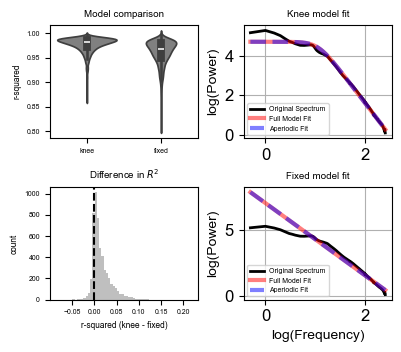

In [37]:
# create figure and gridspec
fig = plt.figure(figsize=[4, 3.5], constrained_layout=True)
spec = gridspec.GridSpec(figure=fig, ncols=2, nrows=2, width_ratios=[1,1], height_ratios=[1,1])
ax1 = fig.add_subplot(spec[0,0])
ax2 = fig.add_subplot(spec[1,0])
ax3 = fig.add_subplot(spec[0,1])
ax4 = fig.add_subplot(spec[1,1])

# plot subplot 1 - violin ----------------------------------------------------------------------
# remove outliers
outlier_thresh_knee = np.nanmean(r2_knee) - 5 * np.nanstd(r2_knee)
outlier_thresh_fixed = np.nanmean(r2_fixed) - 5 * np.nanstd(r2_fixed)
print(f"Removed {len(r2_knee_[r2_knee_<=outlier_thresh_knee])} outliers from knee model")
print(f"Removed {len(r2_fixed_[r2_fixed_<=outlier_thresh_fixed])} outliers from fixed model")

# plot
ax1.set_title('Model comparison')
sns.violinplot(data=[r2_knee_[r2_knee_>outlier_thresh_knee], 
                     r2_fixed_[r2_fixed_>outlier_thresh_fixed]], ax=ax1,
                     color='grey')
ax1.set(xticks=[0, 1], xticklabels=['knee', 'fixed'], ylabel="r-squared")


# plot subplot 2 - histogram ----------------------------------------------------------------------
# compute difference in r-squared betwen models
r2_diff = r2_knee - r2_fixed

# plot
ax2.hist(r2_diff, bins=60, alpha=0.5, label='knee - fixed', color='grey')
ax2.set(xlabel="r-squared (knee - fixed)", ylabel="count")
ax2.axvline(0, color='k', linestyle='--')
ax2.set_title('Difference in $R^2$')

# add text
# ax2.text(0.4, 0.93, f"Channels knee>fixed: {np.sum(r2_diff > 0) / len(r2_diff)*100:.0f}%",
#             horizontalalignment='left', verticalalignment='top',
#             transform=ax2.transAxes, fontsize=8)
# ax2.text(0.4, 0.85, f"Mean difference: {np.nanmean(r2_diff):.3f}",
#             horizontalalignment='left', verticalalignment='top',
#             transform=ax2.transAxes, fontsize=8)

# plot subplot 3 ----------------------------------------------------------------------
fg_k.plot(plt_log=True, ax=ax3)
ax3.legend(loc='lower left')
ax3.set_title('Knee model fit')
ax3.set_xlabel('')
ax3.set_ylabel(ax3.get_ylabel(), fontsize=10)

# plot subplot 4 ----------------------------------------------------------------------
fg_f.plot(plt_log=True, ax=ax4)
ax4.legend(loc='lower left')
ax4.set_title('Fixed model fit')
ax4.set_xlabel(ax4.get_xlabel(), fontsize=10)
ax4.set_ylabel(ax4.get_ylabel(), fontsize=10)

# save and show
plt.savefig(f"{PROJECT_PATH}/figures/supporting_figures/fig_s1.png")
plt.show()

Removed 23 outliers from knee model
Removed 23 outliers from fixed model


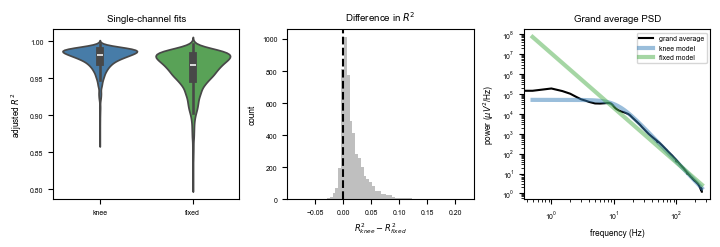

In [40]:
# manuscript figure

REMOVE_OUTLIERS = True

# create figure and gridspec
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[WIDTH['2col'], WIDTH['2col']/3])

# plot subplot 1 - violin ----------------------------------------------------------------------
# remove outliers
if REMOVE_OUTLIERS:
    outlier_thresh_knee = np.nanmean(r2_knee) - 5 * np.nanstd(r2_knee)
    outlier_thresh_fixed = np.nanmean(r2_fixed) - 5 * np.nanstd(r2_fixed)
    print(f"Removed {len(r2_knee_[r2_knee_<=outlier_thresh_knee])} outliers from knee model")
    print(f"Removed {len(r2_fixed_[r2_fixed_<=outlier_thresh_fixed])} outliers from fixed model")

# plot
ax1.set_title('Single-channel fits')
if REMOVE_OUTLIERS:
    sns.violinplot(data=[r2_knee_[r2_knee_>outlier_thresh_knee], 
                        r2_fixed_[r2_fixed_>outlier_thresh_fixed]], ax=ax1,
                        palette=[RGB[2], RGB[1]])
else:
    sns.violinplot(data=[r2_knee_, r2_fixed_], ax=ax1,
                     palette=[RGB[2], RGB[1]])
ax1.set(xticks=[0, 1], xticklabels=['knee', 'fixed'], ylabel="adjusted $R^2$")


# plot subplot 2 - histogram ----------------------------------------------------------------------
# compute difference in r-squared betwen models
r2_diff = r2_knee - r2_fixed

# plot
ax2.hist(r2_diff, bins=60, alpha=0.5, label='knee - fixed', color='grey')
ax2.set(xlabel="$R^2_{knee} - R^2_{fixed}$", ylabel="count")
ax2.axvline(0, color='k', linestyle='--')
ax2.set_title('Difference in $R^2$')

# plot subplot 3 ----------------------------------------------------------------------
ax3.plot(freq, psd, label='grand average', color='k')
ax3.plot(fg_k.freqs, 10**fg_k._ap_fit, color=RGB[2], linewidth=3, alpha=0.5, 
         label='knee model')
ax3.plot(fg_f.freqs,10**fg_f._ap_fit, color=RGB[1], linewidth=3, alpha=0.5, 
         label='fixed model')
ax3.set(xlabel="frequency (Hz)", ylabel="power ($\u03BCV^2$/Hz)")
ax3.set_title('Grand average PSD')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.legend()

# save and show
plt.savefig(f"{PROJECT_PATH}/figures/supporting_figures/fig_s1.png")
plt.show()


In [21]:
# print number of channels with knee model fit better than fixed model
print(f"Channels with knee model fit better than fixed model: {np.sum(r2_diff > 0)} ({np.sum(r2_diff > 0) / len(r2_diff)*100:.0f}%)")

Channels with knee model fit better than fixed model: 4441 (80%)


In [22]:
# run ttest between models
from scipy.stats import ttest_rel

t_stat, p_val = ttest_rel(r2_knee, r2_fixed, nan_policy='omit')
print(f"t-stat: {t_stat:.3f}, p-value: {p_val:.1e}")

t-stat: 52.895, p-value: 0.0e+00
